## Predicting Match Outcome

In [1]:
import sys
sys.path.append(".//utils//")
import sqlite3, os
import pandas as pd
import parsing_utils
from parsing_utils import parse_databases
import importlib
importlib.reload(parsing_utils)
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use("ggplot")
from IPython.display import display_html

### Get match data, drop LPL games, and create a time scale

In [2]:
from sklearn.preprocessing import MinMaxScaler
import math
parser = parse_databases()
db_dir =  ".//databases"
match,random = parser.get_dbs(db_dir)
def drop_empty_cols(matches, minscale = .2):
    thresh = int(matches.shape[0]*.15)
    matches = matches[matches["league"]!= "LPL"].dropna(axis=1, thresh=thresh)
    matches["time"] = MinMaxScaler((minscale,1)).fit_transform(matches.loc[:,["date"]])
    return matches
query = """SELECT * FROM '2016matchdata';"""
matches_16 = drop_empty_cols(pd.read_sql_query(query,match))
query = """SELECT * FROM '2017matchdata';"""
matches_17 = drop_empty_cols(pd.read_sql_query(query,match))
query = """SELECT * FROM '2018matchdata';"""
matches_18 = drop_empty_cols(pd.read_sql_query(query,match), .4)

### Define features of interest

In [3]:
d = [matches_16.columns.values,matches_17.columns.values,matches_18.columns.values]
result = list(set(d[0]).intersection(*d))
to_drop = ["patchno","gameid","url","index","team","gameid","playerid","Team","date","week","split"]
features = pd.Series([x for x in matches_16.columns.values if x in result])
print(list(features.values))
print(features.shape)

['index', 'gameid', 'url', 'league', 'split', 'date', 'week', 'game', 'patchno', 'playerid', 'side', 'position', 'player', 'team', 'champion', 'ban1', 'ban2', 'ban3', 'gamelength', 'result', 'k', 'd', 'a', 'teamkills', 'teamdeaths', 'doubles', 'triples', 'quadras', 'pentas', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd', 'fdtime', 'teamdragkills', 'oppdragkills', 'herald', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills', 'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare', 'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 'oppgoldat10', 'gdat10', 'goldat15', 'oppgoldat15', 'gdat15', 'xpat10', 'oppxpat10', 'xpdat10', 'tim

In [4]:
to_use_players = None
team_feats = ['teamkills', 'teamdeaths', 'fb', 
            'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd', 'fdtime', 'teamdragkills', 
          'oppdragkills', 'herald', 'ft', 'fttime', 'firstmidouter', 'firsttothreetowers', 'teamtowerkills', 
          'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills', 'oppbaronkills', 'dmgtochamps', 
          'dmgtochampsperminute', 'dmgshare', 'earnedgoldshare', 'wards', 'wpm', 'wardkills', 
          'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 'invisiblewardclearrate', 'totalgold', 
          'earnedgpm', 'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 
          'monsterkillsenemyjungle', 'cspm', 'goldat10', 'oppgoldat10', 'gdat10', 'goldat15', 'oppgoldat15', 
          'gdat15', 'xpat10', 'oppxpat10', 'xpdat10', 'result', 'gamelength']

player_feats_past = ['k', 'd', 'a', 'doubles', 'triples', 'quadras', 'pentas', 'fb', 'fbtime', 'gamelength', 
          'fbassist', 'fbvictim', 'kpm', 'fd', 'fdtime', 'dmgtochamps', 'dmgtochampsperminute',
            'dmgshare', 'earnedgoldshare', 'wards', 'wpm', 'wardshare', 'wardkills', 'wcpm', 
        'visionwards', 'visionwardbuys', 'totalgold', 'earnedgpm', 'ft', 'fbaron' , 'fbarontime',
        'goldspent', 'gspd', 'minionkills', 'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle',
        'cspm', 'gdat10', 'gdat15', 'xpdat10', 'result']

player_feats = ['gamelength', 'result', 'k', 'd', 'a', 'teamkills', 'teamdeaths', 'doubles', 'triples', 
                'quadras', 'pentas', 'fb', 'fbassist', 'fbvictim', 'fbtime', 'kpm', 'okpm', 'ckpm', 'fd', 
                'fdtime', 'teamdragkills', 'oppdragkills', 'herald', 'ft', 'fttime', 'firstmidouter', 
                'firsttothreetowers', 'teamtowerkills', 'opptowerkills', 'fbaron', 'fbarontime', 'teambaronkills', 
                'oppbaronkills', 'dmgtochamps', 'dmgtochampsperminute', 'dmgshare', 'earnedgoldshare', 'wards', 
                'wpm', 'wardshare', 'wardkills', 'wcpm', 'visionwards', 'visionwardbuys', 'visiblewardclearrate', 
                'invisiblewardclearrate', 'totalgold', 'earnedgpm', 'goldspent', 'gspd', 'minionkills', 
                'monsterkills', 'monsterkillsownjungle', 'monsterkillsenemyjungle', 'cspm', 'goldat10', 
                'oppgoldat10', 'gdat10', 'goldat15', 'oppgoldat15', 'gdat15', 'xpat10', 'oppxpat10', 'xpdat10']

team_stats = matches_16[matches_16["position"].str.lower() == "team"]
print(len(matches_16["gameid"].unique()))
print(len(player_feats)) #+ len(to_use_players))

2024
64


In [274]:
def make_feats(player_feats, roles=["Top","Jungle","Middle","ADC","Support"]):
    blue_feats = {}
    red_feats = {}
    feats = {}
    all_feats = []
    if roles != None:
        for ii in roles:
            blue_feats[ii] = ["blue"+"_"+ii+"_"+x for x in player_feats]
            red_feats[ii] = ["red"+"_"+ii+"_"+x for x in player_feats]
            all_feats += blue_feats[ii]
            all_feats += red_feats[ii]
        feats = {"Red":red_feats,"Blue":blue_feats}
    else:
        blue_feats = ["blue"+"_"+x for x in player_feats]
        red_feats = ["red"+"_"+x for x in player_feats]
        all_feats += blue_feats
        all_feats += red_feats
        feats = {"Red":red_feats,"Blue":blue_feats}
    return all_feats, feats
    print(len(feats))
    
all_feats, feats = make_feats(player_feats)
team_feats = ['champion', 'ban1', 'ban2', 'ban3', 'ban4', 'ban5']
champ_feats , champ_dict = make_feats(['champion'])
ban_feats , ban_dict = make_feats(['ban1', 'ban2', 'ban3', 'ban4', 'ban5'], roles = None)
team_feats = sorted(champ_feats) + ban_feats
print(champ_dict)
print(ban_dict)

{'Red': {'Top': ['red_Top_champion'], 'Jungle': ['red_Jungle_champion'], 'Middle': ['red_Middle_champion'], 'ADC': ['red_ADC_champion'], 'Support': ['red_Support_champion']}, 'Blue': {'Top': ['blue_Top_champion'], 'Jungle': ['blue_Jungle_champion'], 'Middle': ['blue_Middle_champion'], 'ADC': ['blue_ADC_champion'], 'Support': ['blue_Support_champion']}}
{'Red': ['red_ban1', 'red_ban2', 'red_ban3', 'red_ban4', 'red_ban5'], 'Blue': ['blue_ban1', 'blue_ban2', 'blue_ban3', 'blue_ban4', 'blue_ban5']}


### Make a dict of player stats from previous years

In [275]:
def get_player_dict(to_use, player_feats, scale = True):
    players_dict = pd.DataFrame(index=to_use["player"].unique(),columns=player_feats).fillna(0.0)
    players_dict["num_matches"] = 0
    group = to_use.groupby("player").groups
    for ii in group:
        player_stats = to_use[to_use["player"]==ii].apply(pd.to_numeric, errors = "coerce").fillna(0.0)
        #display(player_stats.loc[:,["k","time"]].mean(axis=0,skipna=False, numeric_only=None))
        if scale:
            players_dict.loc[ii,player_feats] = player_stats.loc[:,player_feats].multiply(player_stats["time"],axis="index").mean(axis=0,skipna=False, numeric_only=None)
        else:
            players_dict.loc[ii,player_feats] = player_stats.loc[:,player_feats].mean(axis=0,skipna=False, numeric_only=None)
        players_dict.loc[ii,"num_matches"] = player_stats.shape[0]
        #display(players_dict.loc[ii,"k"])
    return players_dict

players_2016 = get_player_dict(matches_16,player_feats, scale = True)
players_2017 = get_player_dict(matches_17, player_feats, scale= True)


In [514]:
test = matches_17.copy()
notin = test[~test["player"].isin(matches_16["player"].unique())]
#print(len(matches_16["player"].unique()))
#print(len(matches_18["player"].unique()))
#print(len(notin["player"].unique()))
notin = matches_17[~matches_17["player"].isin(matches_16["player"])]
print(len(notin["player"].unique()))
print(len(matches_17["player"].unique()))
test = matches_16.append(matches_17)
notin = matches_18[~matches_18["player"].isin(test["player"])]
print(len(notin["player"].unique()))
print(len(matches_18["player"].unique()))

305
654
82
380


### Define helper functions

In [276]:
def check_if_new(past_data, current_data, player):
    value = True
    for ii in past_data.keys():
        if player in past_data[ii].index.values:
            value = False
            return value
    for jj in current_data.keys():
        if player in jj:
            value=False
            return value
    return value

def get_average(past_data, role, side, player_feats):
    year = sorted(list(past_data.keys()),reverse=True)[0]
    subset = past_data[year].copy()
    subset.loc[:,player_feats] = subset.loc[:,player_feats].apply(pd.to_numeric, errors = "coerce").fillna(0.0)
    factor = 1
    average = factor*(subset[(subset["position"]==role) & (subset["side"] == side)].loc[:,player_feats]).mean(axis=0, skipna=False, numeric_only = None)
    return average.values

def update_current(current_data,game, player):
    if player not in current_data.keys():
        current_data[player] = game[game["player"] == player]
    else:
        current_data[player] = current_data[player].append(game[game["player"] == player])
    return current_data

def get_stats(past_data, current_data, player=None, player_feats=None):
    n = 0
    tmatches = 0
    stats = pd.Series(index = player_feats).fillna(0)
    if player in current_data.keys():
        #print("Current")
        n+=1
        data = current_data[player]
        stats = data.loc[:,player_feats].apply(pd.to_numeric, errors = "coerce").fillna(0.0).multiply(data["time"],axis="index").sum(axis=0, skipna=False, numeric_only = None)
        tmatches = data.shape[0]
    #print(stats.index.values)
    for ii in sorted(list(past_data.keys()),reverse=True):
        #print("Past")
        pdata = past_data[ii]
        scaling = 1.5**n
        n+=1
        try:
            stats += pdata.loc[player,"num_matches"]* pdata.loc[player,player_feats]/scaling
            tmatches += pdata.loc[player,"num_matches"]
        except:
            continue
    stats = stats/tmatches
    #print(stat_ids)
    return stats.values

In [277]:
average = {}
past_matches = {2016:matches_16}#, 2017:matches_17}
for ii in ["Red" , "Blue"]:
    side = {}
    for jj in ["Top", "Jungle", "Middle", "ADC", "Support"]:
        side[jj] =  get_average(past_matches, jj, ii, player_feats)
    average[ii] = side

In [466]:
import time
past_data = {2016:players_2016, 2017:players_2017}
past_matches = {2016:matches_16, 2017:matches_17}
to_use = matches_18.copy()
match_data = pd.DataFrame(columns = all_feats+["league"], index = to_use["gameid"].unique()).fillna(0.0)
match_data["blue_win"] = 0
def calculate_stats(to_use, past_data, past_matches, match_data):
    current_data = {}
    #display(match_data.head())
    n = 0
    new = 0
    times = []
    overall = time.time()
    for ii in to_use.groupby("gameid").groups:
        start = time.time()
        n+=1
        game = to_use[to_use["gameid"]==ii]

        if game[game["side"]=="Blue"]["result"].unique()[0] == 1:
            match_data.loc[ii,"blue_win"] = 1
        else:
            match_data.loc[ii,"blue_win"] = 0
        match_data.loc[ii,"league"] = game["league"].unique()[0]
        for _,jj in game.iterrows():
            if "team" not in jj["position"].lower():
                role = jj["position"]
                side = jj["side"]
                #print(game[game["player"]==jj]["position"].values)
                #print(game[game["player"]==jj]["side"].values)
                if check_if_new(past_data, current_data, jj["player"]):
                    new +=1
                    #average = get_average(past_matches, role, side, player_feats)
                    match_data.loc[ii,feats[side][role]] = average[side][role]
                else:
                    stats = get_stats(past_data, current_data,jj["player"], player_feats)
                    match_data.loc[ii,feats[side][role]] = stats
                current_data = update_current(current_data,game, jj["player"])
        delta = time.time() - start
        times.append(delta)
        if n % 100 == 0:
            diff = time.time() - overall
            print("Currently on match #: {}".format(n))
            print("Time elapsed to process last batch: {}".format(diff))
            overall = time.time()
        if n > 200000000:
            break
    #display(match_data.head())
    total = len(current_data.keys())
    print("# New Players: {}".format(new))
    print("# Total Players: {}".format(total))
    return match_data,  current_data

match_data, current_data = calculate_stats(to_use, past_data, past_matches, match_data)
#match_data.to_csv("2018_scale_test",sep="\t",index=False)

Currently on match #: 100
Time elapsed to process last batch: 58.109135150909424
Currently on match #: 200
Time elapsed to process last batch: 59.41537642478943
Currently on match #: 300
Time elapsed to process last batch: 53.18748736381531
Currently on match #: 400
Time elapsed to process last batch: 52.789520263671875
Currently on match #: 500
Time elapsed to process last batch: 56.780688762664795
Currently on match #: 600
Time elapsed to process last batch: 56.478395223617554
Currently on match #: 700
Time elapsed to process last batch: 60.996344804763794
Currently on match #: 800
Time elapsed to process last batch: 57.264713764190674
# New Players: 81
# Total Players: 379


In [490]:
match_data = pd.DataFrame(columns = all_feats+["league"], index = ["1"]).fillna(0.0)
match_data["blue_win"] = 0
blue = {'Top':'Hanabi','Jungle':'Moojin','Middle':'Maple','ADC':'Betty','Support':'SwordArT'}
red = {'Top':'Khan','Jungle':'Peanut','Middle':'Bdd','ADC':'Pray','Support':'GorillA'}
#red = ['Khan','Peanut','Bdd', 'Pray', 'GorillA']
players = {"Blue":blue,"Red":red}
print(matches_18[matches_18["team"]=="Flash Wolves"]["player"].unique())
print(matches_18[matches_18["team"].str.contains("King")]["player"].unique())
for ii in players.keys():
    for jj in players[ii].keys():
        role = jj
        side = ii
        player = players[ii][jj]
        #print(game[game["player"]==jj]["position"].values)
        #print(game[game["player"]==jj]["side"].values)
        if check_if_new(past_data, current_data, player):
            new +=1
            #average = get_average(past_matches, role, side, player_feats)
            match_data.loc["1",feats[side][role]] = average[side][role]
        else:
            stats = get_stats(past_data, current_data,player, player_feats)
            match_data.loc["1",feats[side][role]] = stats
match_data["year"] = 2018.0
display(match_data)
#print(match_data.columns.values)
#print(match_all.columns.values)
data = scaler.transform(match_data.drop(labels = ["league","blue_win"],axis=1))
gbm.predict_proba(data)
#print(data)

['Hanabi' 'Moojin' 'Maple' 'Betty' 'SwordArT' 'Team' 'MMD' 'ShiauC'
 'Morning']
['Rascal' 'Peanut' 'Bdd' 'Pray' 'GorillA' 'Team' 'Khan' 'Cuzz']


,blue_Top_gamelength,blue_Top_result,blue_Top_k,blue_Top_d,blue_Top_a,blue_Top_teamkills,blue_Top_teamdeaths,blue_Top_doubles,blue_Top_triples,blue_Top_quadras,...,red_Support_gdat10,red_Support_goldat15,red_Support_oppgoldat15,red_Support_gdat15,red_Support_xpat10,red_Support_oppxpat10,red_Support_xpdat10,league,blue_win,year
1,23.69116,0.605956,1.615607,0.756153,3.786605,8.469457,3.402348,0.230516,0.032936,0.0,...,10.315665,1189.351593,1165.48523,23.866363,980.559517,953.616207,26.943309,0.0,0,2018.0


array([[ 0.67675304,  0.32324693]], dtype=float32)

In [498]:
test = matches_17.loc[:,player_feats].append(matches_18.loc[:,player_feats])
print(test.shape)

(41856, 64)


In [207]:
to_use = matches_18.copy()
match_data = pd.DataFrame(columns = team_feats + ["league"], index = to_use["gameid"].unique())
match_data["blue_win"] = 0
for ii in to_use.groupby("gameid").groups:
    
    game = to_use[to_use["gameid"]==ii]
    
    if game[game["side"]=="Blue"]["result"].unique()[0] == 1:
        match_data.loc[ii,"blue_win"] = 1
    else:
        match_data.loc[ii,"blue_win"] = 0
    match_data.loc[ii,"league"] = game["league"].unique()[0]
    
    for _,jj in game.iterrows():
        role = jj["position"]
        side = jj["side"]
        if "team" not in role.lower():
            match_data.loc[ii,champ_dict[side][role]] = jj["champion"]
        else:
            match_data.loc[ii,ban_dict[side]] = jj.loc[['ban1', 'ban2', 'ban3', 'ban4', 'ban5']].values
            
#match_data.to_csv("2018_match_data_team_comp.txt",sep="\t",index=False)

379
0.5394883203559511


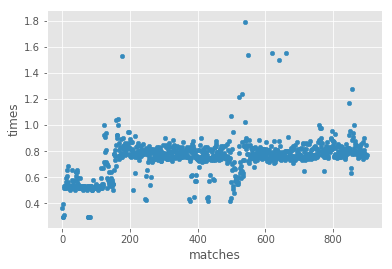

In [282]:
print(len(current_data))
print(match_data["blue_win"].mean(axis=0))
d = pd.DataFrame(times, columns = ["times"])
d["matches"] = d.index.values+1
d.plot.scatter(x="matches",y="times")
plt.show()

In [681]:
#match1 = pd.read_csv("2017_match_data_high_scale_ml.txt",sep="\t")
match1 = pd.read_csv("2017_match_data_high_scale_all_feats_ml.txt",sep="\t")
#match1 = pd.read_csv("2017_match_data_team_comp.txt",sep="\t")
match1["year"] = 2017.0
#match2 = pd.read_csv("2018_match_data_high_scale_ml.txt",sep="\t")
match2 = pd.read_csv("2018_match_data_high_scale_all_feats_ml.txt",sep="\t")
#match2 = pd.read_csv("2018_match_data_team_comp.txt",sep="\t")
match2["year"] = 2018.0
match_all = match1.append(match2)#.sample(frac=1.0)
#print(match_all.dtypes)

0.557742402315


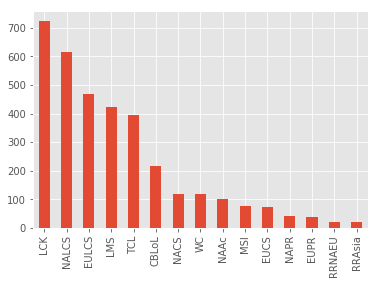

In [682]:
reset_dir()
from sklearn.preprocessing import StandardScaler
import analytics_utils
from analytics_utils import supervised_analysis
import importlib
importlib.reload(analytics_utils)
from sklearn.model_selection import train_test_split

#data = match_all.dropna(how = "any", axis=0).drop("league",axis=1)
def split(match_data, split = True):
    data = match_data.dropna(how = "any", axis=0).drop("league",axis=1, errors = "ignore")
    data_init = pd.get_dummies(data)
    cols = data_init.drop("blue_win",axis=1).columns.values
    y = data_init["blue_win"].values
    scaler = StandardScaler().fit(data_init.drop("blue_win",axis=1))
    data = scaler.transform(data_init.drop("blue_win",axis=1))
    #print("Blue win rate: {:10.3f}".format(data_init["blue_win"].mean(axis=0)))
    if split:
        X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=21, shuffle=True, stratify = y)
        return y, cols, X_train, X_test, y_train, y_test, scaler
    else:
        return y, cols, data, data_init, scaler


#y, cols, data, data_init = split(match_all, False)
y,cols,X_train, X_test, y_train, y_test,scaler = split(match_all, True)
#y, cols, data, data_init, scaler = split(match_all, False)
#m1 = all_matches[all_matches["year"] == 2017]
#m2 = match_all[match_all["year"] == 2018]
#y1, cols1, X_train1, X_test1, y_train1, y_test1 = split(m1)
#y1, _, data1, _ = split(m1, False)

#league = "LCK"

#m2 = match_all[match_all["league"] == league]
#y2, _, data2, _,_ = split(m2, False)
print(match_all["blue_win"].value_counts(normalize=True).iloc[0])
match_all["league"].value_counts().plot.bar()
plt.show()

In [683]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score
def run_classifier(X_train, X_test, y_train, y_test, params = {"max_depth":1, "n_estimators":100, "learning_rate":.1, "colsample_bytree": .5, "subsample": .5, "gamma":0}, cv = True):
    cvresult = None
    clf = xgb.XGBClassifier(max_depth=params["max_depth"], n_estimators=params["n_estimators"], learning_rate=params["learning_rate"], colsample_bytree = params["colsample_bytree"], subsample=params["subsample"], gamma = params["gamma"])
    xgb_param = clf.get_xgb_params()
    if cv:
        #xgtrain = xgb.DMatrix(X_train, label=y_train)
        #cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=5000, nfold=5, metrics=['error'], early_stopping_rounds=10, stratified=True, seed=1301)
        #clf.set_params(n_estimators=cvresult.shape[0])
        cvresult = cross_val_score(clf,X_train,y_train,cv = 5)
    #print(cvresult)
    clf.fit(X_train, y_train)
    
    train_pred = clf.predict(X_train)
    train_acc = accuracy_score(y_train, train_pred)
    #print('Training AUC:', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
    print("Training accuracy: {:10.3f}".format(train_acc))
    
    #pred = clf.predict_proba(X_test, ntree_limit=cvresult.shape[0])
    #print('Testing AUC:', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
    test_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_test, test_pred)
    print("Testing accuracy: {:10.3f}".format(test_acc))
    
    #print('Best number of trees = {}'.format(cvresult.shape[0]))
    #train_pred = clf.predict(X_train)
    #test_pred = clf.predict(X_test)
    #train_acc = accuracy_score(y_train, train_pred)
    #test_acc = accuracy_score(y_test, test_pred)
    #print("Training accuracy: {:10.3f}".format(train_acc))
    #print("Testing accuracy: {:10.3f}".format(test_acc))
    return clf, cvresult


In [684]:
#params = {"max_depth":3, "n_estimators":70, "learning_rate":.08, "colsample_bytree": .5, "subsample": .5, "gamma":0}
#data_init = data_init.sample(frac=1)
#y = data_init["blue_win"].values
#scaler = StandardScaler().fit(data_init.drop("blue_win",axis=1))
#data = scaler.transform(data_init.drop("blue_win",axis=1))
#X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=21, shuffle=True, stratify = y)
#params={"max_depth":3, "n_estimators":50, "learning_rate":.08, "colsample_bytree": .5, "subsample": .5, "gamma":0}
gbm,cvresult = run_classifier(X_train, X_test, y_train, y_test, params, cv=False)
if cvresult is not None:
    #cvresult["train_acc"] = 1 - cvresult["train-error-mean"]
    #cvresult["test_acc"] = 1 - cvresult["test-error-mean"]
    #display(cvresult.loc[:,["train_acc", "train-error-std", "test_acc","test-error-std"]].tail())
    print("CV mean: {:10.4f}\nCV Std: {:10.4f}".format(cvresult.mean(), cvresult.std()))

Training accuracy:      0.749
Testing accuracy:      0.662


In [669]:
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

clf = xgb.XGBClassifier()
params = {  
    "n_estimators": st.randint(3, 100),
    "max_depth": st.randint(1, 40),
    "learning_rate": st.uniform(0.01, 0.4),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 10),
    'reg_alpha': from_zero_positive,
    "min_child_weight": from_zero_positive,
}
gs = RandomizedSearchCV(clf, params, n_jobs=1, cv=5)  
gs.fit(X_train, y_train)  


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
          fit_params=None, iid=True, n_iter=10, n_jobs=1,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A975B63C8>, 'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A975B67B8>, 'learning_rate': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A975B69E8>, 'cols...90>, 'min_child_weight': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000018A975B6390>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
      

In [679]:
clf = gs.best_estimator_
xgb_param = clf.get_xgb_params()
data_init = data_init.sample(frac=1)
y = data_init["blue_win"].values
scaler = StandardScaler().fit(data_init.drop("blue_win",axis=1))
data = scaler.transform(data_init.drop("blue_win",axis=1))
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=21, shuffle=True, stratify = y)
clf.fit(X_train, y_train)d
train_pred = clf.predict(X_train)
train_acc = accuracy_score(y_train, train_pred)
#print('Training AUC:', roc_auc_score(y_train, clf.predict_proba(X_train)[:,1]))
print("Training accuracy: {:10.3f}".format(train_acc))

#pred = clf.predict_proba(X_test, ntree_limit=cvresult.shape[0])
#print('Testing AUC:', roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))
test_pred = clf.predict(X_test)
test_acc = accuracy_score(y_test, test_pred)
print("Testing accuracy: {:10.3f}".format(test_acc))

Training accuracy:      0.741
Testing accuracy:      0.619


In [677]:
print(gs.best_score_)
print(xgb_param)


0.629921259843
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.95189402067426998, 'gamma': 3.4046372184882645, 'learning_rate': 0.23949358694003495, 'max_delta_step': 0, 'max_depth': 13, 'min_child_weight': 4.6529230741397205, 'missing': None, 'n_estimators': 27, 'nthread': 1, 'objective': 'binary:logistic', 'reg_alpha': 26.787472403914908, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 0, 'silent': 1, 'subsample': 0.68356946419822784}


In [561]:
sizes = []
cv_means = []
train = [0.954, 0.869, 0.829, 0.796,  0.781]
test = [0.585, 0.616, 0.614, 0.624, 0.648]
for ii in [.2,.4,.6,.8,1]:
    sample = match_all.sample(frac=ii)
    print("Size of data: {}".format(sample.shape[0]))
    sizes.append(sample.shape[0])
    y,cols,X_train, X_test, y_train, y_test,scaler = split(sample, True)
    gbm,cvresult = run_classifier(X_train, X_test, y_train, y_test, params, cv=True)
    cv_means.append(cvresult.mean())
    print("CV mean: {:10.4f}\nCV Std: {:10.4f}".format(cvresult.mean(), cvresult.std()))

Size of data: 691
Training accuracy:      0.954
Testing accuracy:      0.585
CV mean:     0.6141
CV Std:     0.0305
Size of data: 1382
Training accuracy:      0.869
Testing accuracy:      0.616
CV mean:     0.6041
CV Std:     0.0315
Size of data: 2073
Training accuracy:      0.829
Testing accuracy:      0.614
CV mean:     0.6095
CV Std:     0.0188
Size of data: 2764
Training accuracy:      0.796
Testing accuracy:      0.624
CV mean:     0.6161
CV Std:     0.0296
Size of data: 3455
Training accuracy:      0.781
Testing accuracy:      0.648
CV mean:     0.6216
CV Std:     0.0142


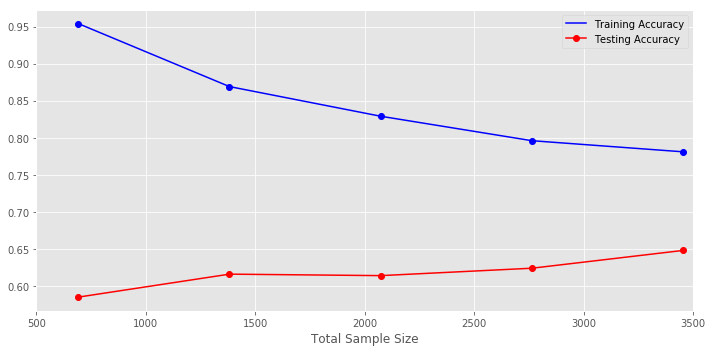

In [591]:
train = [0.954, 0.869, 0.829, 0.796,  0.781]
test = [0.585, 0.616, 0.614, 0.624, 0.648]
df = pd.DataFrame([train,test,cv_means,sizes]).T
df.columns = ["Training Accuracy", "Testing Accuracy", "CV Accuracy", "Total Sample Size"]
df.head()
fig,ax = plt.subplots(1,1,figsize=(10,5))
df.plot.line(x="Total Sample Size",y="Training Accuracy", ax=ax, color = "blue", style =  ["-o"])
df.plot.line(x="Total Sample Size",y="Testing Accuracy", ax=ax, color = "red", style = ["-o"])
plt.xlim((500,3500))
plt.tight_layout()
plt.savefig("Sample_size_vs_accuracy.pdf")
plt.show()

In [685]:
leagues = []
bwin = []
accs = []
num_matches = []
for ii in match_all["league"].unique():
    leagues.append(ii)
    m2 = match_all[match_all["league"] == ii]
    bwin.append(m2["blue_win"].value_counts(normalize=True).iloc[0])
    y2, _, data2, _, _ = split(m2, False)
    pred = gbm.predict(data2)
    acc = accuracy_score(y2, pred)
    accs.append(acc)
    num_matches.append(m2.shape[0])
    #print("Accuracy for {}: {:10.4f}\n".format(ii,acc))
    
s = pd.Series(bwin, index=leagues)
df = pd.DataFrame(s, columns = ["largest_class"])
df["test_acc"] = accs
df["info_gain"] = df["test_acc"]- df["largest_class"]
df["num_matches"] = num_matches
display(df.sort_values(by="info_gain", ascending=False))

,largest_class,test_acc,info_gain,num_matches
LMS,0.575472,0.729858,0.154386,424
EULCS,0.542553,0.689362,0.146809,470
EUCS,0.541667,0.676056,0.134390,72
TCL,0.555838,0.684478,0.128641,394
NACS,0.621849,0.747899,0.126050,119
LCK,0.552486,0.674033,0.121547,724
EUPR,0.605263,0.710526,0.105263,38
NAAc,0.509804,0.613861,0.104057,102
NAPR,0.585366,0.682927,0.097561,41
RRAsia,0.523810,0.619048,0.095238,21


In [86]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression()
#clf = RandomForestClassifier()
rfe = RFE(clf, 20, verbose = 0)
rfe.fit(X_train, y_train)
score = rfe.score(X_test, y_test)
print(score)
rfe.score(X_train, y_train)

0.563947633434


In [90]:
fi1 = pd.DataFrame(gbm.feature_importances_,columns = ["importance"],index=cols).sort_values(by="importance", ascending=False)
#fi1.head(20)

In [686]:
fi2 = pd.DataFrame(gbm.feature_importances_,columns = ["importance"],index=cols).sort_values(by="importance", ascending=False)
fi2.head(10)

,importance
blue_Support_gspd,0.020528
red_Middle_gdat15,0.017595
blue_ADC_gspd,0.017595
red_Jungle_fbaron,0.011730
blue_Support_monsterkillsenemyjungle,0.011730
red_Top_gspd,0.011730
blue_Support_dmgtochamps,0.011730
blue_Middle_gspd,0.011730
red_ADC_result,0.008798
blue_Support_xpdat10,0.008798


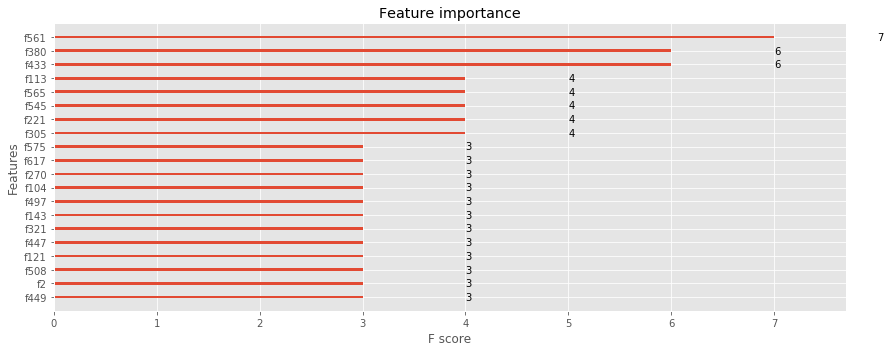

In [687]:
fig, ax =  plt.subplots(1,1,figsize=(12,5))
xgb.plot_importance(gbm, ax= ax, max_num_features = 20)
plt.tight_layout()
plt.show()

In [688]:
s = pd.Series(cols)
s.index = s.index+1
display(all_matches["blue_win"].value_counts(normalize=True))
print(s.iloc[561])
print(s.iloc[380])
print(s.iloc[433])

1    0.57265
0    0.42735
Name: blue_win, dtype: float64

blue_Support_gspd
red_Middle_gdat15
blue_ADC_gspd


In [454]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import sqlite3, os
from scrape_utils import HTMLTableParser
url = "http://www.oddsportal.com/esports/south-korea/league-of-legends-champions-korea-2017/results/"
parser = HTMLTableParser()

['Hanabi' 'Moojin' 'Maple' 'Betty' 'SwordArT' 'Team' 'MMD' 'ShiauC'
 'Morning']
['Rascal' 'Peanut' 'Bdd' 'Pray' 'GorillA' 'Team' 'Khan' 'Cuzz']


In [461]:
current_data["Hanabi"].shape

(24, 105)

### To Consider

I'm getting max 60% accuracy on the match data for both 2017 and 2018 with a naive accuracy of 54% (blue side advantage)... so my model does 6% better than random. How to improve predictions?

- Include league information (standardize this across years and make a union of all leagues) -> This really doesn't help
- Is team composition predictive? - seems to be "no"
- Try doing feature selection/ which features are predictive -> Using all features with xgboost seems to help
- Different models for different leagues or test model on different leauges? -> xgboost works better than any other model
- Am I limited by data - try subsampling matches_all and see if testing accuracy increases with sample size -> slight increase with sample size

66% accuracy with 3 deep trees in xgboost
- Use 2016 match data as well to get more data points -> use 2015 player stats with games played 
- Use xgboost on team comp/early game?
- Use lifetime stats, season stats (last season + this season), and recent game stats (last 10 games)
- New features: on a win streak, largest win streak this season/tournament, early game conversion to wine
- Change tmatches to be the sum of all time scalings
- Performance on best of fives?
- Team synergy -> jungle top, jungle mid, jungle sup synergy


historical odds:
http://www.oddsportal.com/esports/china/league-of-legends-lol-pro-league/results/

## OSHU DATA


In [30]:
import os 
from IPython.display import display
dir1="C:\\Users\Brook Wassie\Dropbox\My Documents\Fraenkel Lab\Projects\\NeuroLincs\AnswerALS\\12_lines\d18_diMNs"
os.chdir(dir1)
df = pd.read_csv("diffbind_matrix.txt",sep="\t")
#columns = [col.replace("DNA171220LH_","").replace("_merged","") for col in df.columns.values]
#df.columns = columns
#df = df.divide(sn.values,axis=1)
df.columns = [name.replace("_diMNs_D18","") for name in df.columns.values]
for_pca = np.log2(df.T)
#labels = [s.split("_")[0] for s in for_pca.index.values]
labels = ["CTR" if "CTR" in name else "ALS" for name in df.columns.values]

print(labels)
#print(df.head())
display(df.head())
#display((df.divide(sn.values,axis=1)).head())

['ALS', 'ALS', 'ALS', 'ALS', 'ALS', 'ALS', 'ALS', 'ALS', 'CTR', 'CTR', 'CTR', 'CTR']


,CS0BUUiALS.n3,CS0LPKiALS.n1,CS6ZLDiALS.n1,CS7VCZiALS.n3,CS29iALS.C9n1.ISOT2RB4,CS29iALS.C9n1,CS52iALS.C9n6.ISOC3,CS52iALS.C9n6,CS0188iCTR.LBCn3,CS0465iCTR.LBCn2,CS0594iCTR.LBCn2,CS0702iCTR.LBCn1_diMNS_D18
chr1_10010_11391,32,20,6,20,2,8,8,4,18,64,10,18
chr1_14309_14458,4,2,2,3,2,1,6,2,4,2,3,4
chr1_15560_15739,1,1,1,1,1,1,1,1,1,1,1,2
chr1_19983_20382,1,1,1,2,2,1,1,1,1,1,1,1
chr1_20397_20627,1,1,1,1,1,1,1,1,1,1,1,1


In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

class scale_pca():
    def __init__(self,data,labels, scale=True):
        if scale:
            scaler = StandardScaler()
            self.scaled = scaler.fit_transform(data)
        else:
            self.scaled = data
        self.data = data
        self.labels = pd.Series(labels)
        
    def pca(self,save=False):
        pca = PCA()
        y = self.labels
        pca_transform = pca.fit(self.scaled).transform(self.scaled)
        dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]
        components = pd.DataFrame(np.round(pca.components_, 4), columns = self.data.keys())
        components.index = dimensions
        components = components[components.iloc[0,:].sort_values(ascending=False).index]
        ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
        variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
        variance_ratios.index = dimensions
        df = pd.concat([variance_ratios, components],axis=1)
        print("\nContributions to PCA components:")
        display(df.head())
        target_names = pd.unique(y)
        print(target_names)
        plt.figure(figsize=(10,5))
        all_colors = ['blue', 'red','green','brown','yellow','cyan','black']
        colors = all_colors[:target_names.shape[0]]
        lw = 2
        for color, i in zip(colors, target_names):
            plt.scatter(pca_transform[y == i, 0], pca_transform[y == i, 1], color=color, alpha=.8, lw=lw,
                        label=i)
        plt.legend(loc='best', shadow=False, scatterpoints=1)
        for label, x, y in zip(self.data.index.values, pca_transform[:, 0], pca_transform[:, 1]):
            plt.annotate(
            label,
            xy=(x, y), xytext=(-20, -20),
            textcoords='offset points', va='bottom')

        plt.title('PCA plot')
        plt.xlabel("Component 1: {}".format(np.round(ratios,4)[0][0]))
        plt.ylabel("Component 2: {}".format(np.round(ratios,4)[1][0]))
        plt.tight_layout()
        if save:
            plt.savefig("PCA.pdf")
            plt.show()
        else:
            plt.show()
        return pca_transform, target_names


Contributions to PCA components:


,Explained Variance,chr4_7835191_7835511,chr10_40678187_40678821,chr16_16232182_16233661,chr22_23907163_23908040,chr6_GL000256v2_alt_1029581_1029767,chr1_124639226_124639580,chr1_KI270892v1_alt_58347_59353,chr1_123290721_123290931,chr5_49292900_49293128,...,chr9_124536636_124537346,chr6_47247041_47248014,chr5_94313749_94314065,chr1_37267025_37267323,chr4_76443295_76443808,chr1_102334090_102334377,chr2_117057006_117057286,chr3_195195250_195197058,chr1_235971587_235972277,chr10_63407165_63407450
Dimension 1,0.3685,0.0024,0.0022,0.0021,0.0021,0.0021,0.0021,0.0021,0.0021,0.0020,...,-0.0032,-0.0032,-0.0032,-0.0032,-0.0032,-0.0032,-0.0032,-0.0032,-0.0032,-0.0032
Dimension 2,0.2125,-0.0002,-0.0009,0.0006,0.0006,-0.0005,0.0002,0.0002,0.0002,0.0007,...,0.0001,0.0001,-0.0001,0.0004,0.0000,-0.0002,0.0003,-0.0002,-0.0003,-0.0006
Dimension 3,0.1345,-0.0006,-0.0002,0.0008,-0.0001,0.0019,0.0009,0.0009,0.0009,-0.0012,...,-0.0000,-0.0003,0.0006,-0.0003,0.0007,0.0003,-0.0002,-0.0003,-0.0006,0.0003
Dimension 4,0.0634,-0.0008,0.0020,-0.0042,-0.0016,-0.0034,-0.0045,-0.0045,-0.0045,0.0015,...,0.0001,-0.0007,0.0001,0.0009,-0.0011,-0.0011,-0.0000,-0.0000,-0.0001,-0.0008
Dimension 5,0.0457,-0.0005,0.0045,-0.0016,-0.0015,0.0007,0.0001,0.0001,0.0001,-0.0044,...,0.0012,0.0004,0.0006,0.0009,-0.0003,-0.0002,-0.0002,0.0011,-0.0007,0.0002


['ALS' 'CTR']


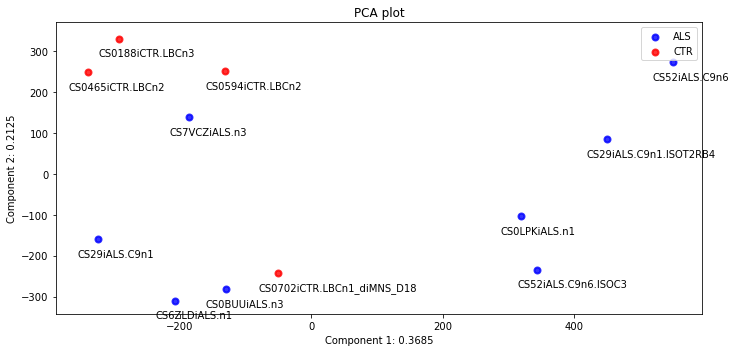

In [32]:
import sys, importlib
sys.path.append('.')
sys.path.append("C:\\Users\Brook Wassie\Dropbox\ssh stuff\\notebooks")
import pca
importlib.reload(pca)

pca = scale_pca(for_pca,labels, True)
y = labels
pca_transform, target_names = pca.pca(True)